In [1]:
#import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.sparse as sparse
import math
import nibabel as nib
import os
from skimage.transform import resize as resize
from scipy.ndimage import label as connection_label
import pandas as pd
import seaborn as sns

In [2]:
def fun_s(u):
    v = []    
    pi = 3.1415926
    power_kappa = 3;
    kappa_max = 15;
    power_sigma = 3;
    lambda_over_dx = 40; # use a common choice for lambda/dx/n_bg
    sigma_over_omega_max = 0.8*(power_sigma+1)*lambda_over_dx/(2*pi);
    kappa = lambda u: 1 + (kappa_max-1)*u**power_kappa;
    sigma_over_omega = lambda u: sigma_over_omega_max*u**power_sigma;
    for i in range(len(u)):
        #print([i, u[i]])
        v.append(complex(kappa(u[i]), sigma_over_omega(u[i])))
    return v

In [3]:
def build_laplacian_1d_PML(N, N_PML_L, N_PML_R):
    # Builds dx^2 times the Laplacian in 1D with effective outgoing boundary
    # condition implemented using PML on the two sides.
    # N = number of grid points
    # N_PML_L = number of PML pixels on the left; zero means no PML
    # N_PML_R = number of PML pixels on the right; zero means no PML

    # f = [f(1), ...., f(N)]
    # df = [df(0.5), ..., df(N+0.5)]
    # d2f = [d2f(1), ...., d2f(N)]
    # put Dirichlet boundary condition behind PML: f(0) = f(N+1) = 0
    # ddx_1*f = df
    # This is dx times (d/dx) operator 
    pi = 3.1415926
    ddx_1 = sparse.spdiags([np.ones(N),-np.ones(N)], [0, -1], N+1, N);

    # ddx_2*df = d2f
    # This is dx times (d/dx) operator 
    ddx_2 = -np.transpose(ddx_1);

    if N_PML_L==0 and N_PML_R==0:
        A = ddx_2*ddx_1;
        return

    # define coordinate-stretching profile s(u)
    power_kappa = 3;
    kappa_max = 15;
    power_sigma = 3;
    lambda_over_dx = 40; # use a common choice for lambda/dx/n_bg
    sigma_over_omega_max = 0.8*(power_sigma+1)*lambda_over_dx/(2*pi);
    #kappa = lambda u: 1 + (kappa_max-1)*u**power_kappa;
    #sigma_over_omega = lambda u: sigma_over_omega_max*u**power_sigma;
    #fun_s = lambda u: complex(kappa(u), sigma_over_omega(u));

    # assign s(u) on interger and half-interger grid points
    # u = 0 on the integer site before PML
    # u = 1 on the integer site after PML (where we put Dirichlet BC)
    s_half = np.array([1+0j for i in range(N+1)]); # column vector
    s_int  = np.array([1+0j for i in range(N  )]); # column vector
    if N_PML_R > 0:
        s_half[(N-N_PML_R):(N+1)] = np.transpose(fun_s(np.arange(0.5,(N_PML_R+1),1)/(N_PML_R+1)))
        s_int[(N-N_PML_R):N] = np.transpose(fun_s(np.arange(1,N_PML_R+1,1)/(N_PML_R+1)))
    if N_PML_L > 0:
        s_half[(N_PML_L)::-1] = np.transpose(fun_s(np.arange(0.5,(N_PML_L+1),1)/(N_PML_L+1)))
        s_int[N_PML_L-1::-1] = np.transpose(fun_s(np.arange(1,N_PML_L+1,1)/(N_PML_L+1)))

    # dx^2 times the Laplacian with PML on the two sides
    A = sparse.spdiags(1./s_int, 0, N, N)*ddx_2*sparse.spdiags(1./s_half, 0, N+1, N+1)*ddx_1;
    
    return A


In [4]:
def  build_laplacian_2d_PML(nx, ny, N_PML_L, N_PML_R, N_PML_B, N_PML_T):
    # Builds dx^2 times the Laplacian in 2D with effective outgoing boundary
    # condition implemented using PML on all four sides.
    # nx = number of grid points in x
    # ny = number of grid points in y
    # N_PML_L = number of PML pixels on the left; zero means no PML
    # N_PML_R = number of PML pixels on the right; zero means no PML
    # N_PML_B = number of PML pixels on the bottom; zero means no PML
    # N_PML_T = number of PML pixels on the top; zero means no PML

    # A = [(d^2/dx^2) + (d^2/dy^2)]*dx^2
    A = sparse.kron(build_laplacian_1d_PML(nx, N_PML_L, N_PML_R), sparse.eye(ny)) + sparse.kron(sparse.eye(nx), build_laplacian_1d_PML(ny, N_PML_B, N_PML_T));
    return A

In [31]:
def transmission_rate(percent1):
    # refractive indices
    n_bg = 1; # air
    n_waveguide = 3.5; # silicon index near lambda = 1.55 micron

    # system dimensions, in micron
    lambda1 = 1.55; # wavelength
    w = 0.3; # waveguide width
    R_in_x = 1.5; # inner radius of bend
    R_in_y = 1.5; # inner radius of bend
    # spacing = 0.5; # waveguide-PML (for visualization)

    # number of PML pixels
    N_PML = 24;

    lambdax = 1.55
    # discretization grid size
    dx = lambdax/n_waveguide/26;
    spacing = 3 * dx

    # number of grid points across the waveguide
    nx_w = int(np.ceil(w/dx));

    # adjust dx slightly so waveguide width w fits into an integer number of grids
    dx = w/nx_w;
    dy = dx;

    # adjust spacing slightly it fits into an integer number of grids
    nx_spacing = round(spacing/dx);
    spacing = nx_spacing*dx;

    # R_in will be discretized into an integer number of grid points since R_in
    # = w here
    nx_R_in = round(R_in_x/dx);
    ny_R_in = round(R_in_y/dy);
    ny_w = ny_R_in

    # total number of pixels in the system
    nx = N_PML + 36 + nx_spacing + nx_R_in + nx_spacing + 36 + N_PML;
    ny = N_PML + nx_spacing + ny_w + nx_spacing + N_PML;

    # have x = 0 & y = 0 being the start of PML
    x = (np.arange(0.5,nx,1) - N_PML - 38)*dx;
    y = (np.arange(0.5,ny,1) - N_PML)*dx;
    x_length = x[-1];
    y_length = y[-1];    
    
    # center position of the waveguide
    length_waveguidey = 0.4;
    y0_waveguide = spacing + R_in_y/2;
    y1_waveguide = spacing + R_in_y/2 + length_waveguidey;
    y2_waveguide = spacing + R_in_y/2 - length_waveguidey;
    x0_waveguide = spacing + w/2;

    # build refractive index profile for the waveguide
    n0_y = n_bg*np.ones(ny);
    n0_y[np.abs(y-y0_waveguide) < w/2] = n_waveguide;
    #n0 = repmat(n0_y, 1, nx);

    # center position of the bend
    x0 = spacing;
    x_startn = int(x0 / dx + N_PML);
    x_guide = x0 + N_PML * dx
    y0 = x0;

    percent2 = 100 - percent1
    #n_path = 'D:/data_ee604_final_project/results/test_data_reduce_simulation_area_wide_265accuracy/1_55_54_46/'
    n_path = 'D:/data_ee604_final_project/results/test_data_reduce_simulation_area_wide_3size_250epoches_align_corner_smooth_separatechannel12_learningrate_suit_alltestdata/1_55_' + str(percent1) + '_' + str(percent2) + '/'
    n_name = 'waveguide_structure_simulation_result.nii.gz'
    n_waveguide_simulation_result_name = os.path.join(n_path, n_name)
    n_waveguide_simulation_result_data = nib.load(n_waveguide_simulation_result_name)
    n_original = n_waveguide_simulation_result_data.get_fdata()
    n = n_original.reshape(48, 48)
    n_copy = n.copy()
    ntransmit = np.zeros([48, 72])
    ntransmit[0:48, 12:60] = n
    for i in range(60, 72):
        ntransmit[ : , i] = n[ : , 47]
    for i in range(0, 12):
        ntransmit[ : , i] = n[ : , 1]

    ntransmit_simulationregion = n[9 : 39, 9 : 39]
    ntransmit_resize = resize(ntransmit_simulationregion, [90, 90], order = 0, mode = 'reflect')

    ntransmit_3interpolation = np.zeros([144, 216])
    for iy in range(0, 144, 3):
        for ix in range(0, 216, 3):
            ntransmit_3interpolation[iy : iy + 3, ix : ix + 3] = np.ones([3, 3]) * ntransmit[int(iy / 3), int(ix / 3)]
    ntransmit_3interpolation[27 : 117, 63 : 153] = ntransmit_resize
    n = ntransmit_3interpolation
    # n = np.where(n <= 2.25, 1.0, 3.5)
    #n[n < 1] = 1
    #n.reshape(96, 96)
    
    print('y0_waveguide = {}, y1_waveguide = {}, y2_waveguide = {}'.format(y0_waveguide, y1_waveguide, y2_waveguide))
    
    x_meshgrid, y_meshgrid = np.meshgrid(x, y)
    
    # k0dx = (omega/c)*dx

    pi = 3.1415926
    k0dx = 2*pi/lambda1*dx;
    print("k0dx = ", k0dx)

    # dx^2 times the shifted eigen operatore for waveguide modes u(y)
    # with effective outgoing boundary condition implemented using PML on the two sides.
    A = build_laplacian_1d_PML(ny, N_PML, N_PML) + sparse.spdiags(k0dx**2*(n0_y**2 - n_waveguide**2), 0, ny, ny);

    # compute first few eigenmodes with n_eff close to n_waveguide
    n_eig = 1;
    [D, V] = sparse.linalg.eigs(A, n_eig, which='SM');

    # convert eigenvalue back to kx
    kxdx_eig1 = np.sqrt(D[0] + (k0dx*n_waveguide)**2)/2
    #kxdx_eig2 = np.sqrt(D[1] + (k0dx*n_waveguide)**2)/2
    #for i in kxdx_eig1:
    kxdx_eig=math.asin(kxdx_eig1)*2

    # effective index
    n_eff_eig = np.array(kxdx_eig)/k0dx

    # transverse profile u_j(y) of the waveguide modes
    u1 = V;
    #u2 = V[:,1];

    u1out = u1 * 0;
    center0 = int(y0_waveguide / dy);
    center1 = int(y1_waveguide / dy);
    center2 = int(y2_waveguide / dy);
    u1out[0 : - (center0 - center2)] = u1[center0 - center2 : ] * np.sqrt(percent1 / 100);
    u1out[center1 - center0 : ] = u1out[center1 - center0 : ] + u1[0 : - (center1 - center0)] * np.sqrt(percent2 / 100);

    u1stout = u1 * 0;
    u1stout[0 : - (center0 - center2)] = u1[center0 - center2 : ]

    u2ndout = u1 * 0;
    u2ndout[center1 - center0 : ] = u1[0 : -(center1 - center0)]

#     fig, axes = plt.subplots(figsize=[8, 6])
#     plt.plot(y, abs(u1out));

    # prefactor for the power of j-th waveguide mode in x direction
    nu1 = np.real(np.sin(kxdx_eig))
    #nu2 = np.real(np.sin(kxdx_eig[1]))
    
    # psi_in(x,y) = u_j(y)*exp(i*kx_j*x)
    kx_1 = kxdx_eig/dx;
    u_1 = V
    psi_in = np.outer(u_1, np.exp(1j*kx_1*x)); #implicit expansion

    # dx^2 times the 2D wave operator for the waveguide + disk system
    # with effective outgoing boundary condition implemented using PML on all four sides.
    A = build_laplacian_2d_PML(nx, ny, N_PML, N_PML, N_PML, N_PML) + sparse.spdiags(k0dx**2*n.flatten('F')**2, 0, nx*ny, nx*ny);

    # dx^2 times the source profile b(x,y)
    # recall x = 0 is the surface of PML
    # n = N_PML + 1 => x_n = dx/2
    # put a surface source at x_n = dx/2, where we want psi_in to have
    # phase exp(1i*kx_1*dx/2)
    b = np.zeros([ny, nx], dtype='complex_');
    b[:, N_PML + 3 + 36 - 1] = 2j*nu1*u1[:,0]*np.exp(1j*kx_1*dx/2);
    #b = -b
    
    # solve A*(psi_out+psi_sca) = b, psi_out+psi_sca = psi_tot when x>0
    #psi_tot = np.reshape(sparse.linalg.spsolve(A,b.flatten('F')), [nx, ny])
    psi_tot = np.reshape(sparse.linalg.spsolve(A,b.flatten('F')), [ny, nx], order = 'F')
    #psi_tot = np.reshape(np.linalg.solve(np.array(A.todense()),b.flatten('F')), [ny, nx])
    
    regulation_connection_factor = 1.0 / (nx * ny * 4 * 10)
    n_prediction = np.where(n > 1.0, 3.5, n)#n.copy()
    continuous_control = np.abs(np.log(np.abs(psi_tot)) * (n_prediction - 1) / (3.5 - 1)) ** 2
    
    # (transmitted power)/(incident power) into each waveguide mode
    # reacall incident wave is in 1st mode
    # at y = 0
    # need to use modes of the outgoing (vertical) waveguides, which in this
    # geometry is the same as modes of the incoming (horizontal) waveguide.
    ind_T = nx - N_PML - 3 - 36 + 1;
    T1out = abs(np.dot(u1out[:,0].T,(psi_tot[:,ind_T].T)))**2
    
    continuous_control_large = np.where(continuous_control >= 0.00009, continuous_control, 0)
    connection_loss_large = np.sum(continuous_control_large[ : , N_PML : nx - N_PML + 1])
    #print("The connection loss of large loss value is: ", connection_loss_large, ".")
    
    T1out1st = abs(np.dot(np.reshape(np.conjugate(u1stout), 144), np.reshape(psi_tot[:,ind_T], [144])))**2
    T1out2nd = abs(np.dot(np.reshape(np.conjugate(u2ndout), 144), np.reshape(psi_tot[:,ind_T], [144])))**2
    #print("The transmitted percentage of the 1st channel is: ", T1out1st / (T1out1st + T1out2nd), ".")
    #print("The transmitted percentage of the 2nd channel is: ", T1out2nd / (T1out1st + T1out2nd), ".")
                   
    T1out_channel = T1out1st + T1out2nd
    #T1out1st = T1out1st / T1out_channel
    #T1out2nd = T1out2nd / T1out_channel
    print("The total transmitted power is: ", T1out_channel, ".")
    print("The transmitted power of the 1st channel is: ", T1out1st, ".")
    print("The transmitted power of the 2nd channel is: ", T1out2nd, ".")
    
    psi_transmission_total = np.zeros([nx])
    for xi in range(0, nx - 1):
        psi_transmission_total[xi] = np.imag(np.dot(np.conjugate(psi_tot[:, xi]), psi_tot[:, xi + 1].T)) / np.sin(kx_1 * (x[1] - x[0]))
    psi_transmission_total[ind_T]
    
    psi_transmission_bottom_continuous = np.zeros([nx])
    for xi in range(0, nx - 1):
        #psi_transmission_bottom_continuous[xi] = np.imag(np.dot(np.conjugate(psi_tot[39 : 57, xi]), psi_tot[39 : 57, xi + 1].T)) / np.sin(kx_1 * (x[1] - x[0]))
        psi_transmission_bottom_continuous[xi] = np.imag(np.dot(np.conjugate(psi_tot[0 : 72, xi]), psi_tot[0 : 72, xi + 1].T)) / np.sin(kx_1 * (x[1] - x[0]))
    
    psi_transmission_top_continuous = np.zeros([nx])
    for xi in range(0, nx - 1):
        #psi_transmission_top_continuous[xi] = np.imag(np.dot(np.conjugate(psi_tot[87 : 105, xi]), psi_tot[87 : 105, xi + 1].T)) / np.sin(kx_1 * (x[1] - x[0]))
        psi_transmission_top_continuous[xi] = np.imag(np.dot(np.conjugate(psi_tot[72 : 144, xi]), psi_tot[72 : 144, xi + 1].T)) / np.sin(kx_1 * (x[1] - x[0]))
    
    #n_waveguide_control = np.where(continuous_control >= 0.00010, 1.0, n)
    #n_waveguide = n;

    if percent1 >= 51:
        return [percent2 / 100, T1out_channel, T1out2nd, T1out1st, 
                psi_transmission_total[ind_T], psi_transmission_top_continuous[ind_T], psi_transmission_bottom_continuous[ind_T]]
    return [percent1 / 100, T1out_channel, T1out1st, T1out2nd, 
            psi_transmission_total[ind_T], psi_transmission_bottom_continuous[ind_T], psi_transmission_top_continuous[ind_T]]

In [32]:
def compare_channels(percent1):
    result_small = transmission_rate(percent1)
    result_large = transmission_rate(100 - percent1)
    if abs(result_small[8] - result_small[0]) + abs(result_small[9] - (100 - result_small[0])) <= abs(result_large[8] - result_large[0]) + abs(result_large[9] - (100 - result_large[0])):
        return result_small
    return result_large

In [33]:
percent1_all = [i for i in range(1, 51, 1)]#2
results_transmission = []
for i in range(50):#25 16
    transmission = transmission_rate(percent1_all[i])
    results_transmission.append(transmission)

y0_waveguide = 0.8, y1_waveguide = 1.2000000000000002, y2_waveguide = 0.4
k0dx =  0.0675611311827957
The total transmitted power is:  0.9933563644269521 .
The transmitted power of the 1st channel is:  0.00845973045443098 .
The transmitted power of the 2nd channel is:  0.9848966339725211 .
y0_waveguide = 0.8, y1_waveguide = 1.2000000000000002, y2_waveguide = 0.4


C:\Users\DELL\AppData\Local\Temp/ipykernel_15272/1821310426.py:117: ComplexWarning: Casting complex values to real discards the imaginary part
  kxdx_eig=math.asin(kxdx_eig1)*2


k0dx =  0.0675611311827957
The total transmitted power is:  0.9925542753206689 .
The transmitted power of the 1st channel is:  0.015122416192968488 .
The transmitted power of the 2nd channel is:  0.9774318591277004 .
y0_waveguide = 0.8, y1_waveguide = 1.2000000000000002, y2_waveguide = 0.4
k0dx =  0.0675611311827957
The total transmitted power is:  0.9959902788767931 .
The transmitted power of the 1st channel is:  0.02445722664132643 .
The transmitted power of the 2nd channel is:  0.9715330522354667 .
y0_waveguide = 0.8, y1_waveguide = 1.2000000000000002, y2_waveguide = 0.4
k0dx =  0.0675611311827957
The total transmitted power is:  0.9975229586223664 .
The transmitted power of the 1st channel is:  0.03497387705709981 .
The transmitted power of the 2nd channel is:  0.9625490815652666 .
y0_waveguide = 0.8, y1_waveguide = 1.2000000000000002, y2_waveguide = 0.4
k0dx =  0.0675611311827957
The total transmitted power is:  0.9964949455783481 .
The transmitted power of the 1st channel is:  0.

The total transmitted power is:  0.9919206761074606 .
The transmitted power of the 1st channel is:  0.30830107290491254 .
The transmitted power of the 2nd channel is:  0.6836196032025481 .
y0_waveguide = 0.8, y1_waveguide = 1.2000000000000002, y2_waveguide = 0.4
k0dx =  0.0675611311827957
The total transmitted power is:  0.9914548886156196 .
The transmitted power of the 1st channel is:  0.3164420885267676 .
The transmitted power of the 2nd channel is:  0.675012800088852 .
y0_waveguide = 0.8, y1_waveguide = 1.2000000000000002, y2_waveguide = 0.4
k0dx =  0.0675611311827957
The total transmitted power is:  0.9910229369003554 .
The transmitted power of the 1st channel is:  0.32479089230141805 .
The transmitted power of the 2nd channel is:  0.6662320445989374 .
y0_waveguide = 0.8, y1_waveguide = 1.2000000000000002, y2_waveguide = 0.4
k0dx =  0.0675611311827957
The total transmitted power is:  0.9906508076498779 .
The transmitted power of the 1st channel is:  0.3333023796798205 .
The transmi

In [34]:
results_transmission_numpy = pd.DataFrame(results_transmission, columns = ['percent1', 'T1out_channel', 'T1out1st', 'T1out2nd', 
                                                                           'psi_transmission_total', 'psi_transmission_1st', 'psi_transmission_2nd'])

In [35]:
results_transmission_numpy = results_transmission_numpy[0 : 49]
results_transmission_numpy

,percent1,T1out_channel,T1out1st,T1out2nd,psi_transmission_total,psi_transmission_1st,psi_transmission_2nd
0,0.01,0.993356,0.008460,0.984897,0.997728,0.010057,0.987671
1,0.02,0.992554,0.015122,0.977432,0.996750,0.015777,0.980974
2,0.03,0.995990,0.024457,0.971533,0.998249,0.024997,0.973252
3,0.04,0.997523,0.034974,0.962549,0.998781,0.035602,0.963178
4,0.05,0.996495,0.045654,0.950840,0.998020,0.046004,0.952016
5,0.06,0.995577,0.055865,0.939712,0.997279,0.056144,0.941135
6,0.07,0.995033,0.066324,0.928710,0.996803,0.066557,0.930246
7,0.08,0.994627,0.076982,0.917645,0.996157,0.077211,0.918947
8,0.09,0.994728,0.083749,0.910979,0.996081,0.084068,0.912013
9,0.10,0.994970,0.089301,0.905669,0.996240,0.089842,0.906398


Text(0, 0.5, 'Energy transmission ratio')

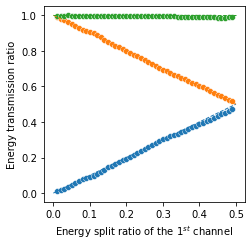

In [36]:
fig, axes = plt.subplots(figsize=[3.6, 3.6])
sns.scatterplot(data=results_transmission_numpy, x='percent1', y='psi_transmission_1st', marker='o', s = 35)
sns.scatterplot(data=results_transmission_numpy, x='percent1', y='psi_transmission_2nd', marker='o', s = 35)
#sns.scatterplot(data=results_transmission_numpy, x='percent1', y='psi_transmission_total', label="Cross section",  marker='o', s = 35)
sns.scatterplot(data=results_transmission_numpy, x='percent1', y='psi_transmission_total', marker='o', s = 35)
plt.plot([0, 0.5], [0, 0.5], '--', linewidth = 1)
plt.plot([0, 0.5], [1, 0.5], '--', linewidth = 1, label = 'Target')
plt.plot([0, 0.5], [1, 1], '--', linewidth = 1)
#axes.legend()
axes.set_xlabel('Energy split ratio of the $1^{st}$ channel')
axes.set_ylabel('Energy transmission ratio')
#plt.savefig('C:/Users/DELL/Desktop/2023年上半年学习和生活的文件/科研的文件/waveguide_structure_design/figures/test_evaluate_0dratiosinputs_weight3_6.svg', dpi = 450)

Text(0, 0.5, 'Actual energy transmission ratio')

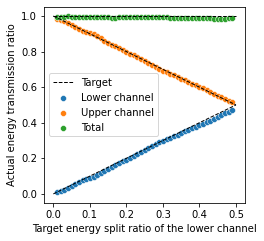

In [37]:
fig, axes = plt.subplots(figsize=[3.6, 3.6])#figsize=[4.6, 4.6]
sns.scatterplot(data=results_transmission_numpy, x='percent1', y='T1out1st', label="Lower channel", marker='o', s = 35)
sns.scatterplot(data=results_transmission_numpy, x='percent1', y='T1out2nd', label="Upper channel", marker='o', s = 35)
#sns.scatterplot(data=results_transmission_numpy, x='percent1', y='psi_transmission_total', label="Cross section",  marker='o', s = 35)
sns.scatterplot(data=results_transmission_numpy, x='percent1', y='T1out_channel', label="Total", marker='o', s = 35)
plt.plot([0, 0.5], [1, 0.5], 'k--', linewidth = 1, label = 'Target')
plt.plot([0, 0.5], [0, 0.5], 'k--', linewidth = 1)
plt.plot([0, 0.5], [1, 1], 'k--', linewidth = 1)
axes.legend()
axes.set_xlabel('Target energy split ratio of the lower channel')
axes.set_ylabel('Actual energy transmission ratio')
#plt.savefig('C:/Users/DELL/Desktop/2023年上半年学习和生活的文件/科研的文件/waveguide_structure_design/figures/test_evaluate_1dinputs_weight.svg', dpi = 450, bbox_inches = 'tight')

In [38]:
print('The average efficiency of the test set is: ',
     results_transmission_numpy['T1out_channel'].mean(), '.')
print('The average energy splitting error is: ',
     (abs(results_transmission_numpy['percent1'] - results_transmission_numpy['T1out1st']).mean() + abs((1.0 - results_transmission_numpy['percent1']) - results_transmission_numpy['T1out2nd']).mean()) / 2, '.')

#abs((1.0 - results_transmission_numpy['percent1']) - results_transmission_numpy['T1out2nd']).mean()

The average efficiency of the test set is:  0.9915736471455571 .
The average energy splitting error is:  0.005671976661822056 .


In [39]:
print('The average efficiency of the test set is: ',
     results_transmission_numpy['psi_transmission_total'].mean(), '.')
print('The average energy splitting error is: ',
     (abs(results_transmission_numpy['percent1'] - results_transmission_numpy['psi_transmission_1st']).mean() + abs((1.0 - results_transmission_numpy['percent1']) - results_transmission_numpy['psi_transmission_2nd']).mean()) / 2, '.')

#abs((1.0 - results_transmission_numpy['percent1']) - results_transmission_numpy['T1out2nd']).mean()

The average efficiency of the test set is:  0.9933906490532911 .
The average energy splitting error is:  0.005420278455806797 .
